In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

%matplotlib inline

In [3]:
import os

num_skipped = 0
for folder_name in ("with_mask", "without_mask"):
    folder_path = os.path.join("/Volumes/LACIE_SHARE/python_scripts/Data/data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
batch_size = 40
img_height = 256
img_width = 256

## loading training data
training_ds = image_dataset_from_directory(
    '/Volumes/LACIE_SHARE/python_scripts/Data/data/',
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size


)

## loading testing data
testing_ds = image_dataset_from_directory(
'/Volumes/LACIE_SHARE/python_scripts/Data/data/',
    labels = 'inferred',
    label_mode = 'categorical',

    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7471 files belonging to 2 classes.
Using 5977 files for training.
Found 7471 files belonging to 2 classes.
Using 1494 files for validation.


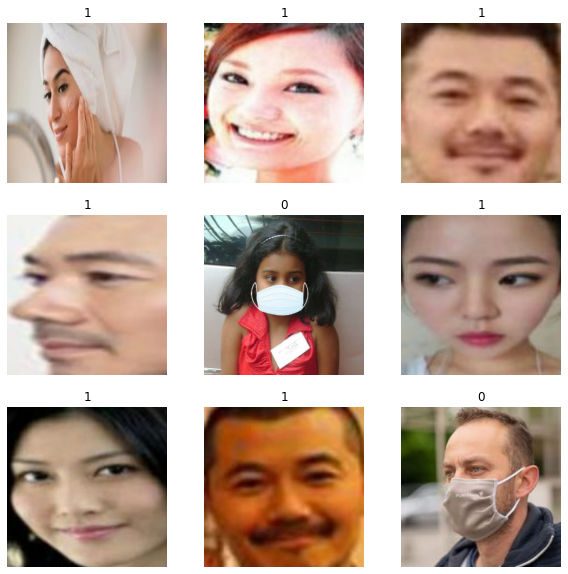

In [6]:
#first ten pictures
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
train_prefetch = training_ds.prefetch(buffer_size=32)
test_prefetch = testing_ds.prefetch(buffer_size=32)

In [10]:
model = keras.applications.Xception(weights=None, input_shape=(img_height, img_width, 3), classes=2)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(training_ds, epochs=10, validation_data=testing_ds)

Epoch 1/10
  1/150 [..............................] - ETA: 0s - loss: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
inputs = keras.Input(shape=input_shape)
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
x = layers.Activation("relu")(x)

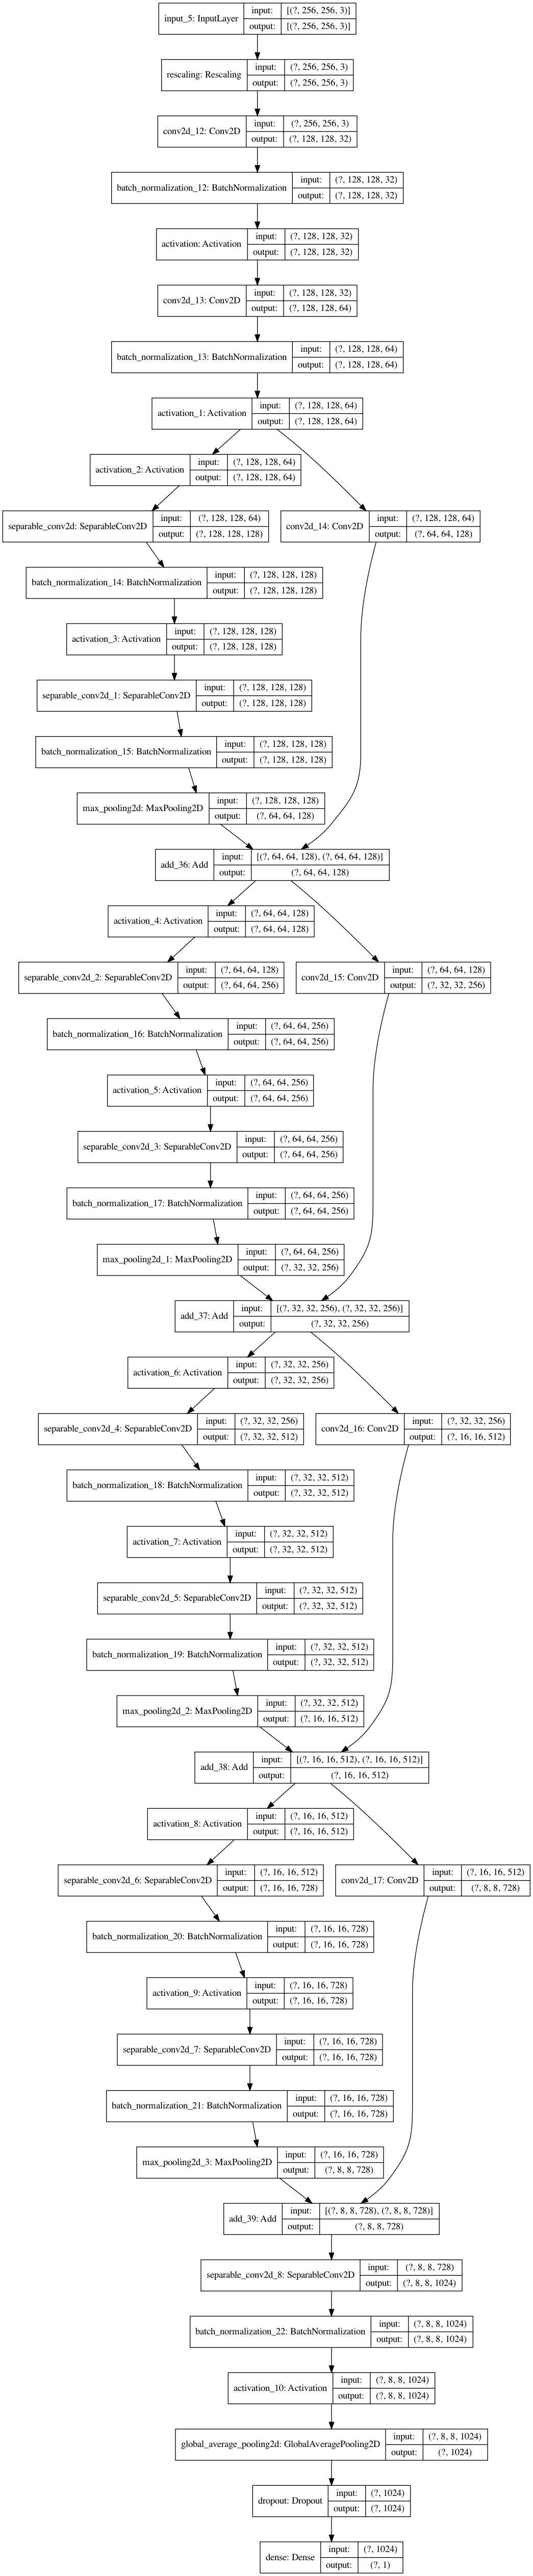

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(img_height, img_width) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_prefetch, epochs=epochs, callbacks=callbacks, validation_data=test_prefetch
)

Epoch 1/50
 58/150 [==========>...................] - ETA: 27:41 - loss: 0.4420 - accuracy: 0.8069

KeyboardInterrupt: 

In [2]:
## New model with resnet


from keras.models import Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [6]:
#re-importing our data so it will go into resnet.

batch_size = 40
img_height = 224
img_width = 224

## loading training data
training_ds = image_dataset_from_directory(
    '/Volumes/LACIE_SHARE/python_scripts/Data/data/',
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size


)

## loading testing data
testing_ds = image_dataset_from_directory(
'/Volumes/LACIE_SHARE/python_scripts/Data/data/',
    labels = 'inferred',
    label_mode = 'categorical',

    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

train_prefetch = training_ds.prefetch(buffer_size=32)
test_prefetch = testing_ds.prefetch(buffer_size=32)

Found 7471 files belonging to 4 classes.
Using 5977 files for training.
Found 7471 files belonging to 4 classes.
Using 1494 files for validation.


In [17]:
resnet50 = applications.resnet50.ResNet50(include_top=True)

for layer in resnet50.layers:
    layer.trainable=False

# index -2 is the penultimate layer. 
embedding_layer = resnet50.get_layer(index=-2)
embedding_layer_out = embedding_layer.output
embedding_layer

In [22]:

resnet50_input = resnet50.input
new_classification_output = Dense(2, activation='softmax')(embedding_layer_out)
new_model = Model(inputs=resnet50_input, outputs=new_classification_output)

new_model.summary()

new_model.compile(optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [23]:
log_dir = "/Volumes/LACIE_SHARE/Software/anaconda3/tensorflow_logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [24]:
epochs = 10
callbacks = [tensorboard_callback]

new_model.fit(train_prefetch, 
              epochs=epochs, callbacks=callbacks, validation_data=test_prefetch)

Epoch 1/10
  1/150 [..............................] - ETA: 0s - loss: 0.5839 - accuracy: 0.7000WARNING:tensorflow:From /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
150/150 [==============================] - 1014s 7s/step - loss: 0.0917 - accuracy: 0.9694 - val_loss: 0.0491 - val_accuracy: 0.9819
Epoch 2/10
150/150 [==============================] - 2367s 16s/step - loss: 0.0305 - accuracy: 0.9913 - val_loss: 0.0467 - val_accuracy: 0.9799
Epoch 3/10
150/150 [==============================] - 923s 6s/step - loss: 0.0212 - accuracy: 0.9955 - val_loss: 0.0315 - val_accuracy: 0.9886
Epoch 4/10
150/150 [==============================] - 905s 6s/step - loss: 0.0167 - accuracy: 0.9970 - val_loss: 0.0333 - val_accuracy: 0.9866
Epoch 5/10
150/150

In [32]:
from tensorflow.keras.models import Sequential, save_model, load_model
save_model(new_model, "/Volumes/LACIE_SHARE/python_scripts/Data/data")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Volumes/LACIE_SHARE/python_scripts/Data/data/assets


In [8]:
from tensorflow.keras.models import load_model
new_model = load_model("/Volumes/LACIE_SHARE/python_scripts/Data/data", compile = True)

In [46]:
y_pred = new_model.predict(test_prefetch) > .5

KeyboardInterrupt: 

In [20]:
predictions = np.array([])
probs = np.array([])
labels =  np.array([])

for x, y in test_prefetch:
  predictions = np.concatenate([predictions, np.argmax(new_model.predict(x), axis=1)]) ##will give us the max of whatever class
  probs = np.concatenate([probs, new_model.predict(x)[:,1]])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

binary_labels = (labels ==3).astype('int') #not sure why it cast the labels as 2 and 3

In [10]:
from sklearn import metrics

In [35]:
metrics.confusion_matrix(binary_labels, predictions)


array([[724,   6],
       [  7, 757]])

In [77]:
metrics.f1_score(binary_labels, predictions)

0.991486574983628

In [36]:
metrics.accuracy_score(binary_labels, predictions)

0.9912985274431058

In [37]:
metrics.precision_score(binary_labels, predictions)

0.9921363040629095

In [38]:
metrics.recall_score(binary_labels, predictions)


0.9908376963350786

ValueError: in user code:

    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Volumes/LACIE_SHARE/Software/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv1_pad is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [32, 224, 3]


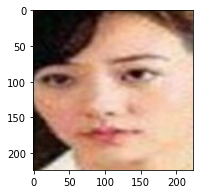

In [46]:

#first ten pictures
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_prefetch:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(np.argmax(new_model.predict(images[i]), axis=1))
        plt.axis("off")

AttributeError: module 'numpy' has no attribute 'levels'

array([3., 3., 2., ..., 2., 2., 3.])

array([1., 1., 0., ..., 0., 0., 1.])

array([1, 1, 0, ..., 0, 0, 1])